# Network visualization

Last updated: 08232023  
By: Lauren Liao  
Purpose: from top word similarity matrix 

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import scipy
import scipy.cluster.hierarchy as sch

%matplotlib inline

**Data loading**  
the data starts with the preprocessed text (pickled) file with top 10 variables and top 30 variables

In [2]:
# read processed text from previous
top10_lst =  pd.read_pickle("../results/top10_mean.pkl")
top30_lst =  pd.read_pickle("../results/top30_mean.pkl")

## Visualize top 10 for network

1. specifying all nodes
2. find the duplication
3. plot all connections and label KEYTERMS and connection words (duplicated)

In [3]:
all_nodes = [item for sublist in [[x[0]] for x in top10_lst] + 
             [[k for k in x[1].keys()] for x in top10_lst] for item in sublist]

In [4]:
duplicated_words = [word for word, count in Counter(all_nodes).items() if count > 1]
# duplicated_words

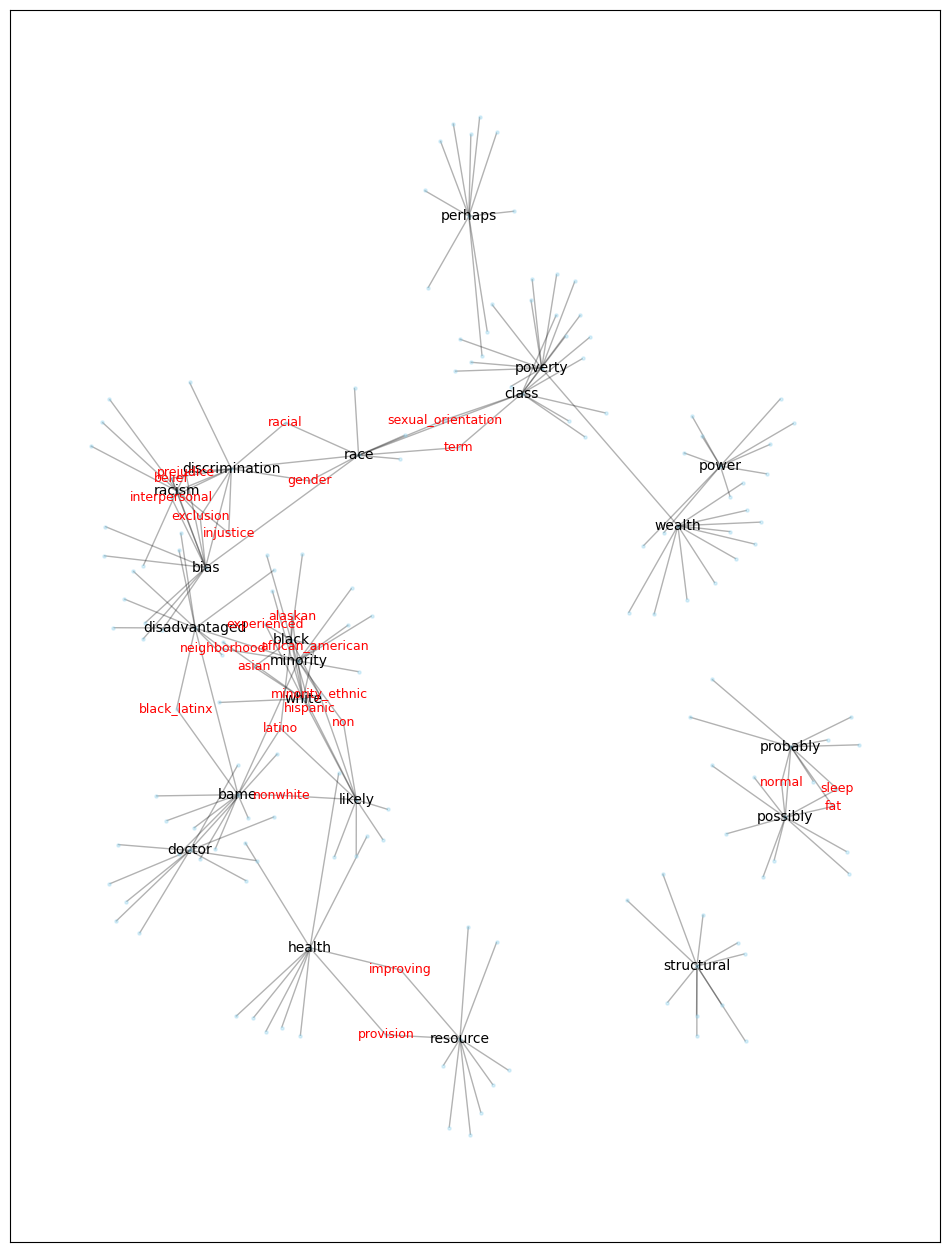

In [5]:
np.random.seed(1234567891)

# create an empty graph
G = nx.Graph()

# adding nodes
G.add_nodes_from(all_nodes)

# adding edges
for word_lst in top10_lst:
    word, word_related_dict = word_lst
    for related_word, weight in word_related_dict.items():
        G.add_edge(word, related_word, weight=weight*0.1)

plt.figure(figsize=(12, 16))
pos_layout = nx.spring_layout(G)
# Manual tweaking to limit node label overlap in the visualization
# pos_layout["discrimination"] += (0.1, -0.10)
pos_layout["bias"] += (0.03, -0.06)
pos_layout["racism"] += (0.05, -0.03)
pos_layout["bame"] += (0.05, -0.05)
pos_layout["white"] += (0.05, -0.05)
pos_layout["likely"] += (0.05, -0.05)
pos_layout["neighborhood"] += (-0.05, -0.05)

nx.draw_networkx(G, pos_layout, with_labels=False, node_size=5, node_color='skyblue', alpha=0.3)
nodes_with_labels = [x[0] for x in top10_lst]  # specify the nodes for which you want to display labels
node_labels = {node: node for node in nodes_with_labels}
nx.draw_networkx_labels(G, pos=pos_layout, labels=node_labels, font_size=10)

# add additional red labels
additional_labels = set(duplicated_words) - set(node_labels.keys())
additional_label_colors = {node: node for node in additional_labels}
nx.draw_networkx_labels(G, pos=pos_layout, labels=additional_label_colors, font_size=9, font_color='red')


plt.show()

### Find connections of specific duplication words for top 30

leveraging the network to find (harder to visualize top 30)

In [6]:
all_nodes30 = [item for sublist in [[x[0]] for x in top30_lst] + 
               [[k for k in x[1].keys()] for x in top30_lst] for item in sublist]
duplicated_words30 = [word for word, count in Counter(all_nodes30).items() if count > 1]

In [7]:
np.random.seed(1234567891)

# create an empty graph
G = nx.Graph()

# adding nodes
G.add_nodes_from(all_nodes30)

# adding edges
for word_lst in top30_lst:
    word, word_related_dict = word_lst
    for related_word, weight in word_related_dict.items():
        G.add_edge(word, related_word, weight=weight*0.1)

In [8]:
[print(f"'{connect_word}': {list(G.neighbors(connect_word))}") 
 for connect_word in set(duplicated_words30) - set(node_labels.keys()) if len(list(G.neighbors(connect_word))) > 3];

'predominantly': ['black', 'white', 'bame', 'likely']
'historical': ['racism', 'discrimination', 'power', 'bias']
'native_american': ['black', 'white', 'bame', 'minority', 'likely']
'racial': ['race', 'racism', 'discrimination', 'bias']
'african_american': ['black', 'white', 'minority', 'likely']
'gender': ['race', 'racism', 'discrimination', 'bias']
'latino': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'nonwhite': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'experienced': ['black', 'white', 'minority', 'likely']
'minority_ethnic': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'stereotype': ['race', 'racism', 'discrimination', 'bias']
'prejudice': ['race', 'racism', 'discrimination', 'bias']
'black_latinx': ['bame', 'minority', 'disadvantaged', 'likely']
'sexual_orientation': ['class', 'race', 'discrimination', 'bias']
'implicit': ['race', 'racism', 'discrimination', 'bias']
'interpersonal': ['race', 'racism', 'discriminat

### Scipy correlation clustering
Goal: clustering with correlation hierarchical clustering on all the words above that are of interest/ connection

source: https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb

In [23]:
many_connect_words = [(connect_word, list(G.neighbors(connect_word))) 
 for connect_word in set(duplicated_words30) - set(node_labels.keys()) if len(list(G.neighbors(connect_word))) > 3];

In [31]:
main_terms = [a for a,b in many_connect_words]
key_terms = [term for a,b in many_connect_words for term in b]
connect_all = main_terms + key_terms

In [9]:
mean_similarity_df = pd.read_pickle("../data/similarity_df_mean.pkl")
std_similarity_df = pd.read_pickle("../data/similarity_df_std.pkl")

In [10]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

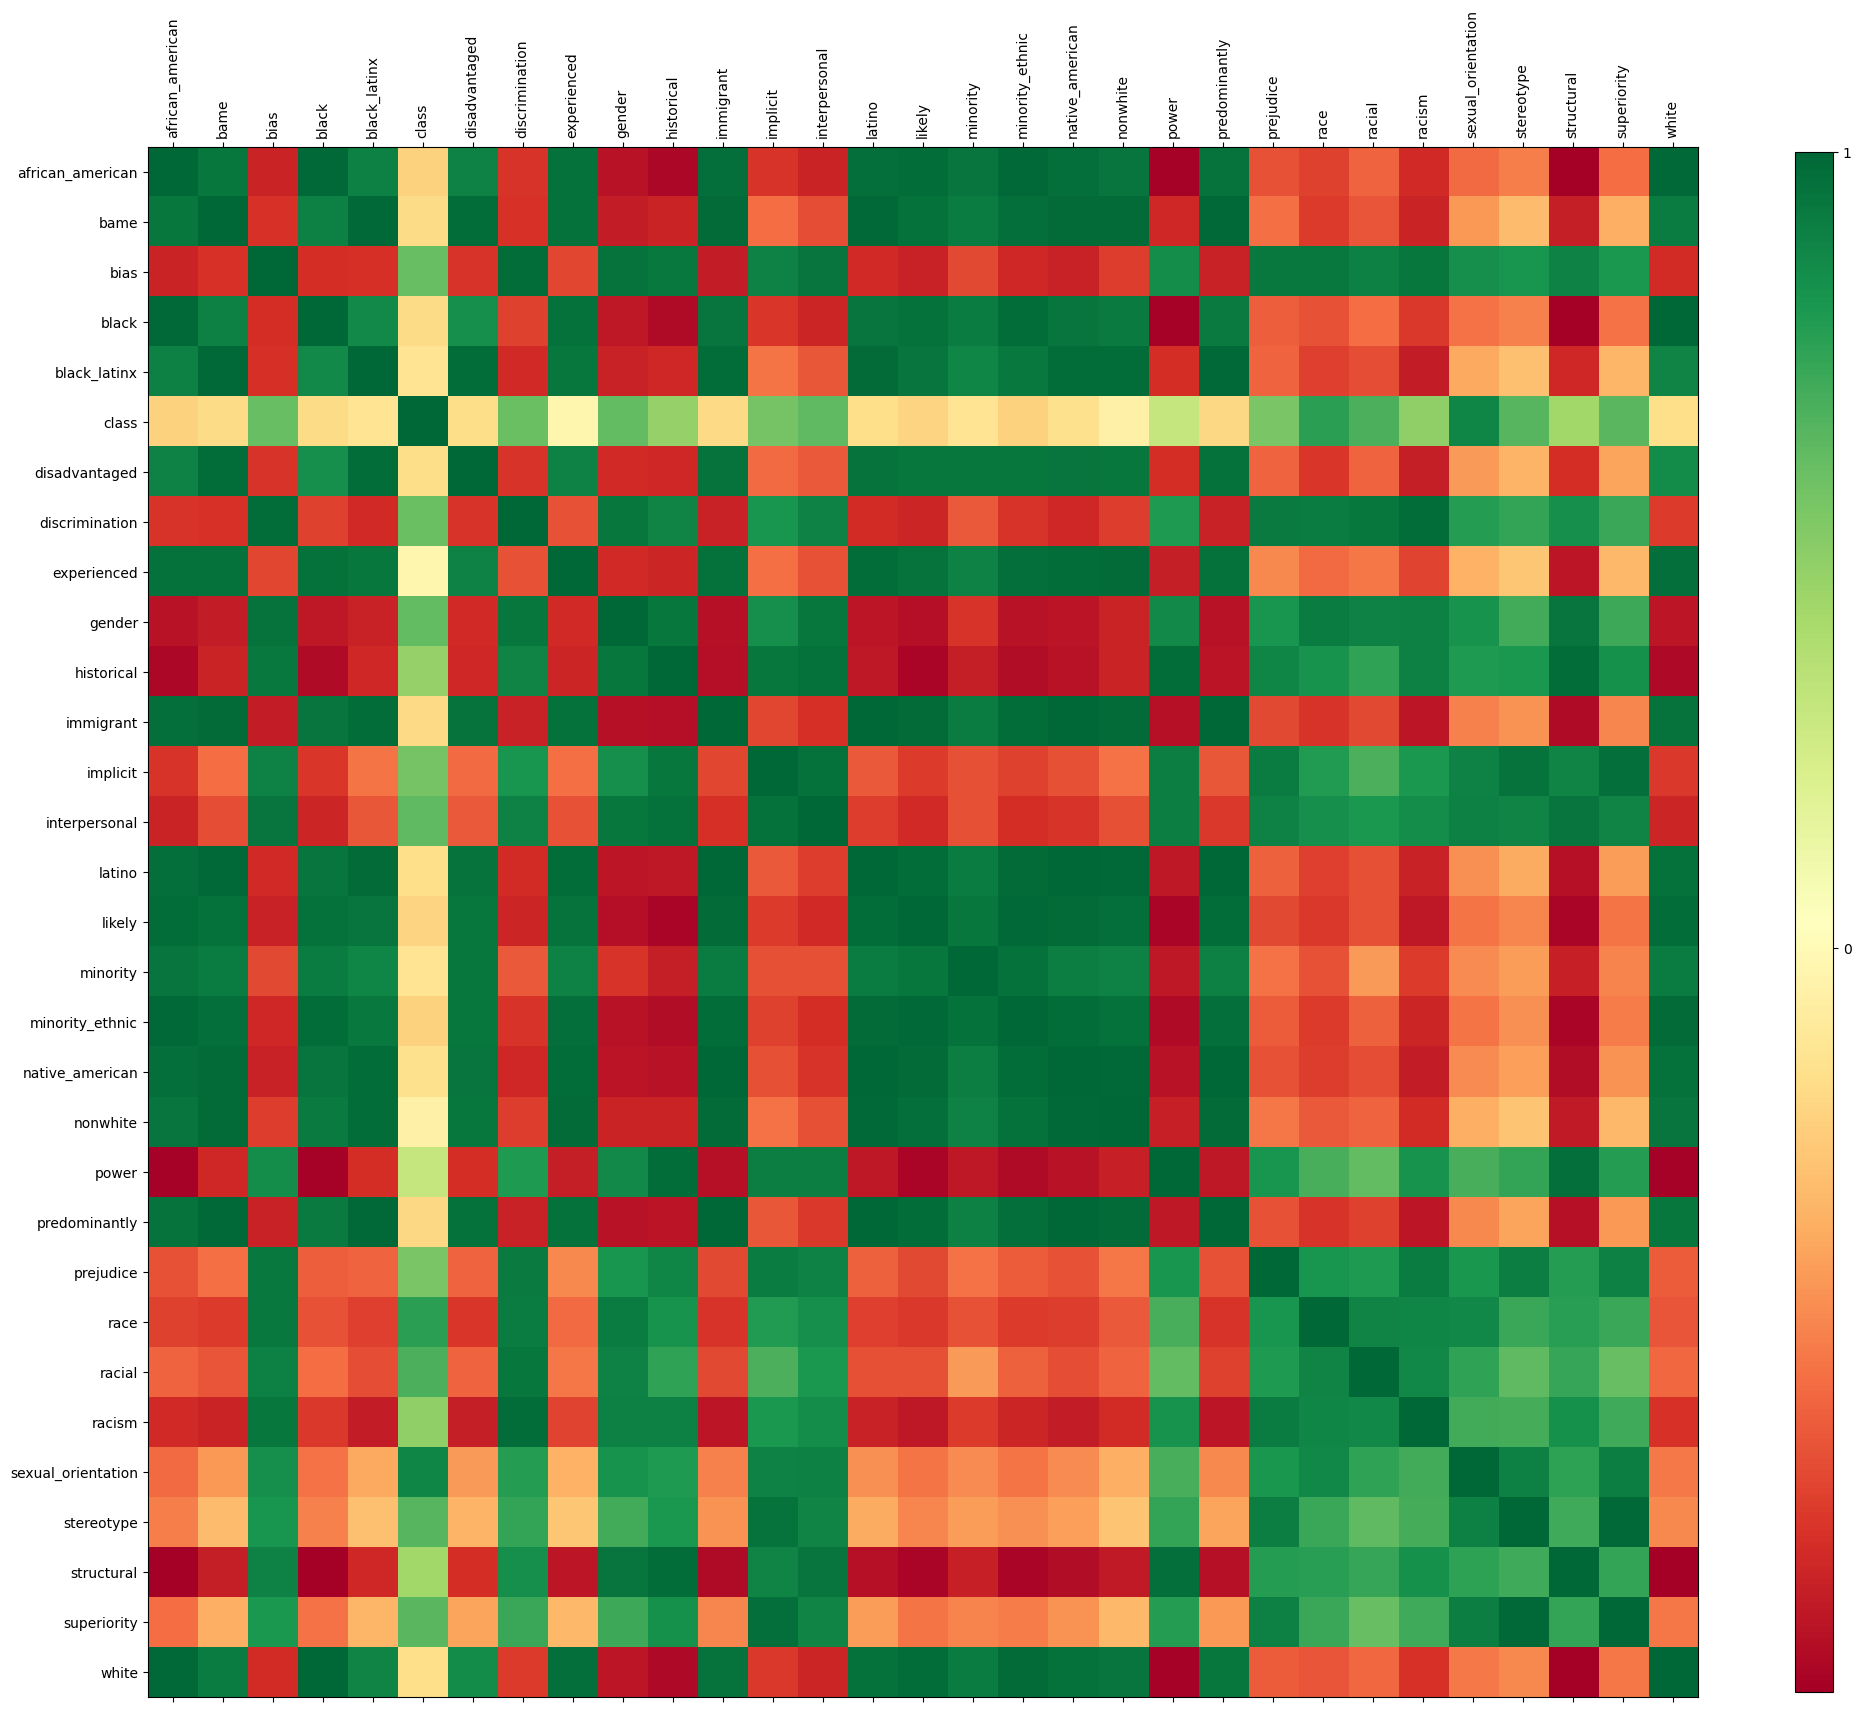

In [40]:
plot_corr(mean_similarity_df.loc[list(np.unique(connect_all)), list(np.unique(connect_all))], size=25)

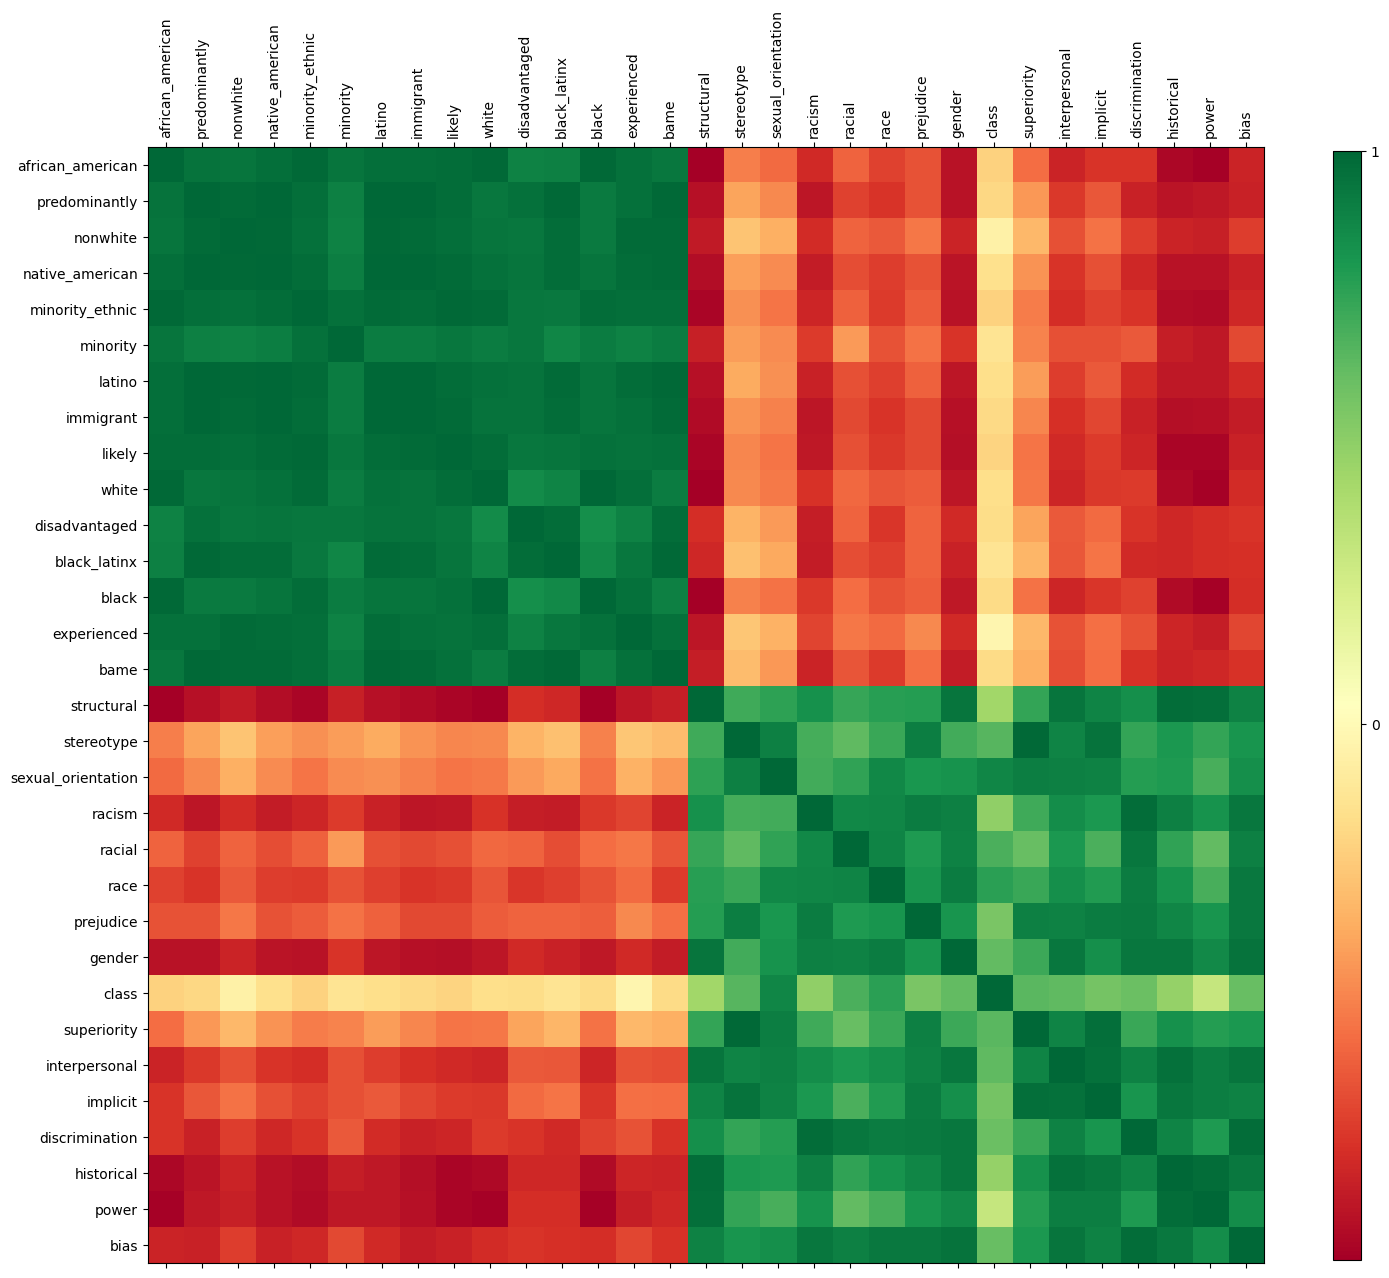

In [41]:
df = mean_similarity_df.loc[list(np.unique(connect_all)), list(np.unique(connect_all))]
X = df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

plot_corr(df, size=18)

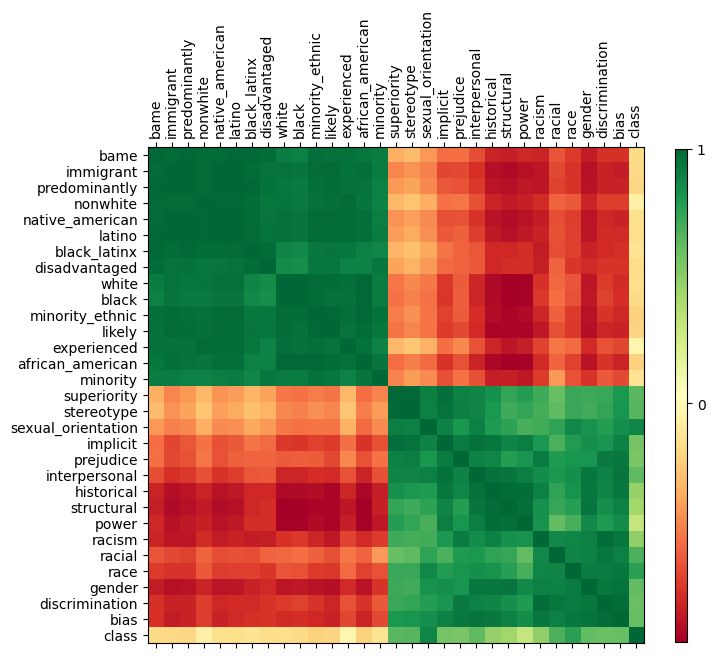

In [46]:
# Two pass clustering
# 1-We cluster the corr matrix
#   We sort the data according to this clustering
# 2-For cluster bigger than a threshold we cluster those sub-clusters
#   We sort the data according to these clustering

cluster_th = 4

X = df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')

columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
df = df.reindex(columns, axis=1)

unique, counts = np.unique(ind, return_counts=True)
counts = dict(zip(unique, counts))

i = 0
j = 0
columns = []
for cluster_l1 in set(sorted(ind)):
    j += counts[cluster_l1]
    sub = df[df.columns.values[i:j]]
    if counts[cluster_l1]>cluster_th:        
        X = sub.corr().values
        d = sch.distance.pdist(X)
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
        sub = sub.reindex(col, axis=1)
    cols = sub.columns.tolist()
    columns.extend(cols)
    i = j
df = df.reindex(columns, axis=1)

plot_corr(df, 8)